In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import wrds

In [2]:
from datetime import datetime
import time

In [207]:
import matplotlib.pyplot as plt

In [3]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Enter your WRDS username [ec2-user]: ly229
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## 1. Prepare Data for Regression

### i) Loading CRSP daily stock data

#### Testing
- (see a lot higher vol to shrout) so check for stocks that trading volume is smaller than share of outstanding to see whether there is a mistake

In [22]:
start_time_ins = time.time()
test_query = """
        SELECT DISTINCT 
            cusip, 
            date AS date,
            ret AS return,
            bid,ask,
            vol as volume,
            shrout AS shares_outstanding,
            ABS(prc) AS price            
            
    
        FROM 
            crsp.dsf

        WHERE 
            date BETWEEN '2023-09-01' AND '2023-12-31'
        
        ORDER BY
            date;
"""

try:
    test_result = conn.raw_sql(test_query)
    print(test_result)
except Exception as e:
    print("Error executing test query:", e)

end_time_ins = time.time()
execution_time_ins = end_time_ins - start_time_ins

print(f"Execution time for test query: {execution_time_ins:.4f} seconds")

           cusip        date    return    bid    ask     volume  \
0       00032Q10  2023-09-01 -0.069841   5.85   5.86   136489.0   
1       00036020  2023-09-01  0.041231  65.65  65.66   460862.0   
2       00036110  2023-09-01 -0.001461  61.49  61.51   144170.0   
3       00038020  2023-09-01  0.009284  22.82  22.84  8055326.0   
4       00039J10  2023-09-01 -0.000378  50.04  50.06    20292.0   
...          ...         ...       ...    ...    ...        ...   
281498  Y8897Y23  2023-12-29  0.000000  15.31  15.62    24892.0   
281499  Y8900D10  2023-12-29 -0.019920   4.92   4.95    36927.0   
281500  Y9233510  2023-12-29  0.008163   2.46   2.47    42984.0   
281501  Y9390M10  2023-12-29 -0.031250   8.37   8.38  2808199.0   
281502  Y9530810  2023-12-29 -0.001976   5.04   5.05   693952.0   

        shares_outstanding    price  
0                  24520.0   5.8600  
1                  81609.0  65.6600  
2                  34989.0  61.5100  
3                 214632.0  22.8300  
4    

In [27]:
start_time_ins = time.time()
test_query_1 = """
        SELECT DISTINCT 
            cusip, 
            date AS date,
            ret AS return,
            bid,ask,
            vol as volume,
            shrout AS shares_outstanding,
            ABS(prc) AS price            
            
    
        FROM 
            crsp.dsf

        WHERE 
            date BETWEEN '2023-09-01' AND '2023-12-31'
            AND prc IS NOT NULL
            AND ret IS NOT NULL
            AND shrout IS NOT NULL
            AND bid IS NOT NULL
            AND ask IS NOT NULL
"""

try:
    test_result_1 = conn.raw_sql(test_query_1)
    print(test_result_1)
except Exception as e:
    print("Error executing test query:", e)

end_time_ins = time.time()
execution_time_ins = end_time_ins - start_time_ins

print(f"Execution time for test query: {execution_time_ins:.4f} seconds")

           cusip        date    return     bid     ask     volume  \
0       78463X47  2023-10-31  0.005486   48.79   48.86    47084.0   
1       82489W10  2023-09-07 -0.008479   19.88   19.89  2943534.0   
2       50189K10  2023-10-02  0.001363  117.58  117.59   256282.0   
3       74347R17  2023-11-29  0.029091   19.77   19.82   108286.0   
4       65481N10  2023-10-09 -0.058140    2.42    2.43   216516.0   
...          ...         ...       ...     ...     ...        ...   
280675  39957D20  2023-10-13 -0.160622    1.57    1.62   195424.0   
280676  00174410  2023-12-07  0.004380   68.76   68.77   397947.0   
280677  03071H10  2023-11-08 -0.004318   50.67   50.75    59276.0   
280678  46435U36  2023-11-16 -0.026110   33.56   33.72    62440.0   
280679  12950010  2023-10-16  0.030022   27.78   27.79   371983.0   

        shares_outstanding   price  
0                  12150.0   48.88  
1                 169940.0   19.88  
2                  25324.0  117.58  
3                   397

In [13]:
len(test_result.cusip.unique())

3056

In [11]:
print(test_result.loc[test_result['cusip'] == '37954Y18'])

          cusip        date    return    bid    ask  volume  \
2214   37954Y18  2023-12-29 -0.003916  16.33  16.39   530.0   
18805  37954Y18  2023-12-28 -0.002801  16.39  16.45  1343.0   

       shares_outstanding    price  
2214                610.0  16.3557  
18805               610.0  16.4200  


In [26]:
file_name = "crsp_daily.csv"

start_year = 1993
current_year = datetime.now().year

for year in range(start_year, current_year + 1):
    
    print(f"Downloading data for the year {year}...")
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    query = f"""
        SELECT DISTINCT 
            cusip, 
            date AS date,
            ret AS return,
            bid,ask,
            vol as volume,
            shrout AS shares_outstanding,
            ABS(prc) AS price            
            
    
        FROM 
            crsp.dsf

        WHERE 
            date BETWEEN '{start_date}' AND '{end_date}'
            AND prc IS NOT NULL
            AND ret IS NOT NULL
            AND shrout IS NOT NULL
            AND bid IS NOT NULL
            AND ask IS NOT NULL
        
    """
    
    # Fetch data for the current year
    year_data = conn.raw_sql(query)
    
    # Append the data to the CSV file
    if year == start_year:
        # Write with header if it's the first year
        year_data.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # Append without header if it's not the first year
        year_data.to_csv(file_name, mode='a', header=False, index=False)
    
    print(f"Data for year {year} appended to '{file_name}'")

Data for year 1993 appended to 'crsp_daily.csv'
Data for year 1994 appended to 'crsp_daily.csv'
Data for year 1995 appended to 'crsp_daily.csv'
Data for year 1996 appended to 'crsp_daily.csv'
Data for year 1997 appended to 'crsp_daily.csv'
Data for year 1998 appended to 'crsp_daily.csv'
Data for year 1999 appended to 'crsp_daily.csv'
Data for year 2000 appended to 'crsp_daily.csv'
Data for year 2001 appended to 'crsp_daily.csv'
Data for year 2002 appended to 'crsp_daily.csv'
Data for year 2003 appended to 'crsp_daily.csv'
Data for year 2004 appended to 'crsp_daily.csv'
Data for year 2005 appended to 'crsp_daily.csv'
Data for year 2006 appended to 'crsp_daily.csv'
Data for year 2007 appended to 'crsp_daily.csv'
Data for year 2008 appended to 'crsp_daily.csv'
Data for year 2009 appended to 'crsp_daily.csv'
Data for year 2010 appended to 'crsp_daily.csv'
Data for year 2011 appended to 'crsp_daily.csv'
Data for year 2012 appended to 'crsp_daily.csv'
Data for year 2013 appended to 'crsp_dai

### ii) Resampling - daily to quarterly

In [115]:
crsp_daily = pd.read_csv("crsp_daily.csv")

#### Testing of Resampling

In [15]:
sample_crsp = crsp_daily.sample(n=100000, random_state=42)

In [20]:
print(sample_crsp.loc[sample_crsp['cusip'] == '00037520'])

             cusip       date    return    bid    ask    volume  \
37068003  00037520 2013-03-12 -0.005245  22.75  22.76  916300.0   

          shares_outstanding  price  
37068003            133827.0  22.76  


In [24]:
sample_crsp['date'] = pd.to_datetime(sample_crsp['date'])

def geometric_mean(x):
   return np.exp(np.log(1+x).mean()) - 1

#Group by year and quarter, aggregating the desired columns
sample_quarterly = sample_crsp.groupby(['cusip', pd.Grouper(key='date', freq='QE')]).agg({
    'ask': 'mean',               # Average ask price
    'bid': 'mean',               # Average bid price
    'price': 'mean',             # Average price
    'volume': 'sum',             # Total trading volume
    'shares_outstanding': 'last', # Last value of shares outstanding
    'return': geometric_mean  # Cumulative return
}).reset_index()

#Reset index if needed (optional)
sample_quarterly.reset_index(inplace=True)

print(sample_quarterly)

      index     cusip       date     ask      bid    price      volume  \
0         0  00036020 2007-03-31  27.920  27.8800  27.9200     24346.0   
1         1  00037520 2013-03-31  22.760  22.7500  22.7600    916300.0   
2         2  00039J20 2023-06-30  24.930  24.9100  24.9150     29833.0   
3         3  00057310 1993-06-30   3.875   3.6875   3.6875    404250.0   
4         4  00078110 1993-03-31  17.000  16.2500  17.0000     21150.0   
...     ...       ...        ...     ...      ...      ...         ...   
9948   9948  Y8564W10 2011-03-31  35.840  35.8300  35.8000    643900.0   
9949   9949  Y8565N30 2010-06-30  12.380  12.3700  12.4000    318400.0   
9950   9950  Y8897Y23 2009-09-30   1.730   1.7100   1.7100     52018.0   
9951   9951  Y8897Y23 2021-03-31   1.960   1.9500   1.9700  12342754.0   
9952   9952  Y9530810 2022-09-30   3.380   3.3600   3.3600    129291.0   

      shares_outstanding    return  
0                12339.0  0.002154  
1               133827.0 -0.005245  


In [26]:
crsp_daily['date'] = pd.to_datetime(crsp_daily['date'])

def geometric_mean(x):
   return np.exp(np.log(1+x).mean()) - 1

#Group by year and quarter, aggregating the desired columns
crsp_quarterly = crsp_daily.groupby(['cusip', pd.Grouper(key='date', freq='QE')]).agg({
    'ask': 'mean',               # Average ask price
    'bid': 'mean',               # Average bid price
    'price': 'mean',             # Average price
    'volume': 'sum',             # Total trading volume
    'shares_outstanding': 'last', # Last value of shares outstanding
    'return': geometric_mean  # Cumulative return
}).reset_index()

# Step 6: Reset index if needed (optional)
crsp_quarterly.reset_index(inplace=True)

# Step 7: Display the result
print(crsp_quarterly)

         index     cusip       date       ask       bid     price      volume  \
0            0  00002130 1993-03-31  1.108871  0.933972  1.015625    820439.0   
1            1  00002130 1993-06-30  1.321925  1.173115  1.243056   4598634.0   
2            2  00002130 1993-09-30  3.105469  2.971191  3.049805   6395409.0   
3            3  00002130 1993-12-31  2.686523  2.548340  2.621582   3166675.0   
4            4  00002130 1994-03-31  2.394841  2.244048  2.321925   2519814.0   
...        ...       ...        ...       ...       ...       ...         ...   
957766  957766  Y9530810 2022-12-31  4.619206  4.601905  4.607778  43426321.0   
957767  957767  Y9530810 2023-03-31  4.591613  4.576774  4.581855  27327539.0   
957768  957768  Y9530810 2023-06-30  4.043387  4.029194  4.038790  26489301.0   
957769  957769  Y9530810 2023-09-30  4.571746  4.559048  4.564921  18258199.0   
957770  957770  Y9530810 2023-12-31  5.346825  5.334762  5.344841  35502283.0   

        shares_outstanding 

In [30]:
file_path_1 = 'crsp_quarterly.csv' 
crsp_quarterly.to_csv(file_path_1, index=False)

## 2) Baseline OLS Regression

### i) Construct Dependent Varaibles - Market Quality
- price efficiency
- liquidity
- volatility

### i-1) Liquidity and Volatility

In [5]:
crsp_quarterly = pd.read_csv('crsp_quarterly.csv') 
df_regression = pd.read_csv("df_regression.csv")

In [77]:
#prepare an empty dataframe for regression variables

columns = [
    'cusip',             # CUSIP identifier
    'date',              # end of the quarter
    'bas',               # bid-ask spread
    'tno',               # turnover ratio/share turnover
    'illiq',             # average Amihud illiquidity for the quarter
    'volatility',        # idiosyncratic volatility over the quarter
    'synch',             # stock synchronicity
    'autocorr',          # autocorrelation of returns
    'ind_own',           # index ownership
    'mktcap'             # maket capitalization in million
    'price_ind',         # 1/average price for the quarter
    'volume',            # total trading volume in million
    'act_own',           # active ownership
    'ins_own'            # instituinal ownership
]

# Create an empty DataFrame with the specified columns
df_regression = pd.DataFrame(columns=columns)

In [45]:
# Liquidity: bid-ask spread, turnover ratio/share turnover
crsp_quarterly['bas'] = crsp_quarterly['ask'] - crsp_quarterly['bid']
crsp_quarterly['tno'] = crsp_quarterly['volume'] / crsp_quarterly['shares_outstanding']
crsp_quarterly['mktcap'] = crsp_quarterly['price'] * crsp_quarterly['volume']/1000000
crsp_quarterly['price_ind'] = 1 / crsp_quarterly['price']

In [52]:
crsp_quarterly_merge = crsp_quarterly.copy()

In [53]:
selected_columns = ['cusip', 'date', 'bas', 'tno', 'mktcap', 'price_ind','volume']
crsp_quarterly_merge = crsp_quarterly_merge[selected_columns]

In [55]:
crsp_quarterly_merge.loc[:,'volume'] = crsp_quarterly_merge['volume']/1000000

#### obtain easy calculation ones and leave others as nans

In [78]:
df_regression = crsp_quarterly_merge.assign(illiq=np.nan, 
                                             volatility=np.nan,
                                             synch=np.nan,
                                             autocorr=np.nan,
                                             ind_own=np.nan,
                                             act_own=np.nan,
                                             ins_own=np.nan)

#### Amihud Illiqudity Measure

In [41]:
def amihud_illiquidity(daily_data):

    # Ensure the date column is in datetime format
    daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Calculate the Amihud illiquidity for each day, scaled up by 100 million for better readability    
    daily_data['illiquidity'] = np.abs(daily_data['return']) / (daily_data['price'] * daily_data['volume'])*100000000
    
    # Step 2: Group by CUSIP and quarter, and calculate the average illiquidity measure
    illiquidity = daily_data.groupby(['cusip', pd.Grouper(key='date', freq='QE')]).agg(
        illiquidity=('illiquidity', 'mean')  # Average illiquidity over the quarter
    ).reset_index()
    
    return illiquidity

In [21]:
crsp_daily_amihud = crsp_daily[crsp_daily['volume'] != 0].reset_index(drop=True)

In [42]:
df_illiquidity = amihud_illiquidity(crsp_daily_amihud)
df_illiquidity

,cusip,date,illiquidity
0,00002130,1993-03-31,3206.893230
1,00002130,1993-06-30,2962.366077
2,00002130,1993-09-30,20.606325
3,00002130,1993-12-31,57.773551
4,00002130,1994-03-31,146.438422
...,...,...,...
956177,Y9530810,2022-12-31,3.353258
956178,Y9530810,2023-03-31,1.842007
956179,Y9530810,2023-06-30,2.416159
956180,Y9530810,2023-09-30,2.952670


In [86]:
df_illiquidity.rename(columns={'illiq': 'illiq_m'}, inplace=True)

In [66]:
'''# Check if 'date' column is of datetime type
is_datetime = pd.api.types.is_datetime64_any_dtype(df_illiquidity['date'])
print(f"'date' column is of datetime type: {is_datetime}")'''

'date' column is of datetime type: True


In [68]:
df_regression['date'] = pd.to_datetime(df_regression['date'])

In [69]:
df_merge = pd.merge(df_regression, df_illiquidity,
                         on=['cusip', 'date'], how='left')

NameError: name 'df_illiquidity' is not defined

In [90]:
df_regression['illiq'] = df_merge['illiq_m']

#### Volatility - calculate daily and convert to quarterly

In [20]:
def quarterly_volatility(daily_data):
    
    daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Calculate the standard deviation of daily returns within each quarter
    quarterly_volatility = daily_data.groupby(['cusip', pd.Grouper(key='date', freq='QE')]) \
        .agg(daily_std=('return', 'std'), trading_days=('return', 'count')).reset_index()
    
    # Calculate quarterly volatility by scaling daily std dev to quarterly
    quarterly_volatility['quarterly_volatility'] = quarterly_volatility['daily_std'] * np.sqrt(quarterly_volatility['trading_days'])
    
    return quarterly_volatility[['cusip', 'date', 'trading_days', 'quarterly_volatility']]

          cusip       date  trading_days  quarterly_volatility
0      00002130 1996-09-30             2              0.113553
1      00030710 2017-03-31             1                   NaN
2      00032Q10 2022-06-30             1                   NaN
3      00036020 1999-03-31             1                   NaN
4      00036020 1999-06-30             1                   NaN
...         ...        ...           ...                   ...
94997  Y9369110 2010-12-31             1                   NaN
94998  Y9384M10 2014-12-31             1                   NaN
94999  Y9530810 2022-09-30             1                   NaN
95000  Y9530810 2023-06-30             1                   NaN
95001  Y9530810 2023-12-31             1                   NaN

[95002 rows x 4 columns]


In [22]:
df_vol = quarterly_volatility(crsp_daily)

print(df_vol)
#trading days is around 60 per quarter

           cusip       date  trading_days  quarterly_volatility
0       00002130 1993-03-31            62              0.954526
1       00002130 1993-06-30            63              1.258872
2       00002130 1993-09-30            64              0.392466
3       00002130 1993-12-31            64              0.462112
4       00002130 1994-03-31            63              0.602037
...          ...        ...           ...                   ...
957766  Y9530810 2022-12-31            63              0.649561
957767  Y9530810 2023-03-31            62              0.375254
957768  Y9530810 2023-06-30            62              0.302115
957769  Y9530810 2023-09-30            63              0.345499
957770  Y9530810 2023-12-31            63              0.440173

[957771 rows x 4 columns]


In [63]:
df_regression['date'] = pd.to_datetime(df_regression['date'])

In [66]:
df_vol_1 = df_vol.drop(columns=['trading_days'])
df_vol_1.rename(columns={'quarterly_volatility': 'volatility'}, inplace=True)

In [70]:
df_merge = pd.merge(df_regression, df_vol_1,
                         on=['cusip', 'date'], how='left')

In [75]:
df_regression

,cusip,date,bas,tno,mktcap,price_ind,volume,illiq,volatility,synch,autocorr,ind_own,act_own,ins_own
0,00002130,1993-03-31,0.174899,106.357143,0.833258,0.984615,0.820439,3206.893230,0.954526,NaN,NaN,NaN,NaN,NaN
1,00002130,1993-06-30,0.148810,596.141302,5.716358,0.804469,4.598634,2962.366077,1.258872,NaN,NaN,NaN,NaN,NaN
2,00002130,1993-09-30,0.134277,809.852982,19.504748,0.327890,6.395409,20.606325,0.392466,NaN,NaN,NaN,NaN,NaN
3,00002130,1993-12-31,0.138184,400.997214,8.301698,0.381449,3.166675,57.773551,0.462112,NaN,NaN,NaN,NaN,NaN
4,00002130,1994-03-31,0.150794,300.049297,5.850818,0.430677,2.519814,146.438422,0.602037,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957766,Y9530810,2022-12-31,0.017302,499.721764,200.098837,0.217024,43.426321,3.353258,0.649561,NaN,NaN,NaN,NaN,NaN
957767,Y9530810,2023-03-31,0.014839,278.553988,125.210817,0.218252,27.327539,1.842007,0.375254,NaN,NaN,NaN,NaN,NaN
957768,Y9530810,2023-06-30,0.014194,269.099028,106.984733,0.247599,26.489301,2.416159,0.302115,NaN,NaN,NaN,NaN,NaN
957769,Y9530810,2023-09-30,0.012698,184.457927,83.347229,0.219062,18.258199,2.952670,0.345499,NaN,NaN,NaN,NaN,NaN


In [74]:
df_regression = df_regression.drop(columns=['volatility_x'])
df_regression['volatility'] = df_merge['volatility_y']

In [178]:
file_path_2 = 'df_regression.csv' 
df_regression.to_csv(file_path_2, index=False)

### i-2) Price Efficiency

#### -i) Stock Synchronicity

In [148]:
# load Fama-French data(daily)
ff_data = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows=3) 
ff_data.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RF']  # Rename columns
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')
ff_data.set_index('date', inplace=True)
ff_data = ff_data.apply(pd.to_numeric, errors='coerce') / 100  # Convert to decimal form

In [152]:
# Convert the index back to a column
ff_data_merg = ff_data.reset_index()

# The index column will be named 'index' by default; rename it to 'Date'
ff_data_merg.rename(columns={'index': 'Date'}, inplace=True)

In [153]:
ff_data_merg.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)

#### run FF-regression for each stock in every quarter

In [123]:
crsp_merg = crsp_daily[['cusip', 'date', 'return']].copy()

In [124]:
crsp_merg['date'] = pd.to_datetime(crsp_merg['date'])

In [157]:
#left merge on date so all cusip in the same date filled with same value
ff_merged_data = pd.merge(crsp_merg, ff_data_merg, on='date', how='left')

# Check data, this merge by date fills all cusips within same date same value
print("Merged DataFrame:")
print(ff_merged_data)

Merged DataFrame:
             cusip       date    return     MKT     SMB     HML       RF
0         09073M10 1993-04-22  0.036364 -0.0074  0.0093 -0.0031  0.00011
1         58844810 1993-05-27  0.016129 -0.0016  0.0039  0.0045  0.00011
2         93448810 1993-04-08 -0.027174 -0.0022  0.0002  0.0078  0.00011
3         71270810 1993-02-25  0.006623  0.0042  0.0016  0.0006  0.00012
4         85440210 1993-08-04 -0.049180 -0.0001  0.0020  0.0012  0.00011
...            ...        ...       ...     ...     ...     ...      ...
58342003  90915J10 2023-06-08 -0.002016  0.0059 -0.0049 -0.0115  0.00019
58342004  67069910 2023-03-29  0.012533  0.0139 -0.0030 -0.0053  0.00016
58342005  90214Q73 2023-03-03  0.014706  0.0161  0.0000 -0.0052  0.00016
58342006  55826T10 2023-01-03 -0.026685 -0.0048  0.0008 -0.0012  0.00017
58342007  25460E52 2023-05-23  0.090820 -0.0109  0.0039  0.0105  0.00016

[58342008 rows x 7 columns]


In [159]:
ff_merged_data['excess_return'] = ff_merged_data['return'] - ff_merged_data['RF']

In [186]:
file_path_3 = 'ff_merged_data.csv' 
ff_merged_data.to_csv(file_path_3, index=False)

#### define FF regression function

In [166]:
selected = ['85440210', '90915J10', '58844810']
df_ff_test = ff_merged_data[ff_merged_data['cusip'].isin(selected)]

In [161]:
def ff_regression(data):
    # Prepare the dependent and independent variables
    X = data[['MKT', 'SMB', 'HML']]
    y = data['excess_return']
    X = sm.add_constant(X)  # Add a constant term for the intercept
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Return relevant results
    return {
        'r_squared': model.rsquared,
        'MKT_coef': model.params['MKT'],
        'SMB_coef': model.params['SMB'],
        'HML_coef': model.params['HML']
    }

In [176]:
unique_cusips = ff_merged_data['cusip'].unique()
unique_cusips_ct = len(unique_cusips)
print("Unique CUSIPs:", unique_cusips_ct)

Unique CUSIPs: 27607


#### Define autocrrelation function for lags of 1-4 quarters

In [184]:
def autocorr_all_lag_df(data, returns_col='returns', max_lag=4):
    # Calculate autocorrelation for each lag
    autocorrs = {f'auto_lag{lag}': data[returns_col].autocorr(lag=lag) for lag in range(1, max_lag + 1)}
    
    # Convert to a single-row DataFrame
    autocorr_df = pd.DataFrame([autocorrs])
    
    return autocorr_df

In [185]:
start_time_ins = time.time()

results = []  # Initialize the results list

# Loop through unique CUSIPs
unique_cusips = df_ff_test['cusip'].unique()
unique_cusips_ct = len(unique_cusips)
print("Unique CUSIPs:", unique_cusips_ct)

for cusip in unique_cusips:
    # Filter the data for the specific CUSIP
    cusip_data = df_ff_test[df_ff_test['cusip'] == cusip]
    print(f"Processing CUSIP: {cusip}, Number of rows: {cusip_data.shape[0]}")

    # Group data by quarter
    for quarter, group in cusip_data.groupby('quarter'):

        
        if len(group) >= 3:  # Ensure you have enough data points for regression
            result = ff_regression(group)  # Replace with your regression function

            # Now call the function with the entire DataFrame
            autocorr_df = autocorr_all_lag_df(df_ff_test, returns_col='return', max_lag=4)

            result = {**result, **autocorr_df.iloc[0].to_dict()} # Merge autocorr_df into result

            result['cusip'] = cusip
            result['quarter'] = str(quarter)  # Store quarter as a string
            results.append(result)  # Append the result to the list

# Convert results to DataFrame
test_df_ff_reg = pd.DataFrame(results)

# Check the results
print("Final Results DataFrame Shape:", test_df_ff_reg.shape)
print(test_df_ff_reg.head())

end_time_ins = time.time()
execution_time_ins = end_time_ins - start_time_ins

print(f"Execution time for test query: {execution_time_ins:.4f} seconds")

Unique CUSIPs: 3
Processing CUSIP: 58844810, Number of rows: 6136
Processing CUSIP: 85440210, Number of rows: 1756
Processing CUSIP: 90915J10, Number of rows: 2104
Final Results DataFrame Shape: (160, 10)
   r_squared  MKT_coef  SMB_coef  HML_coef  auto_lag1  auto_lag2  auto_lag3  \
0   0.023144  0.288575  0.905014 -0.488032  -0.005603  -0.009717   0.002379   
1   0.061853  1.245118  4.360052  0.569277  -0.005603  -0.009717   0.002379   
2   0.065911  4.763082  2.427374  8.275322  -0.005603  -0.009717   0.002379   
3   0.071423  4.227016  4.429811  5.985292  -0.005603  -0.009717   0.002379   
4   0.070321  3.564854  0.542551  6.643165  -0.005603  -0.009717   0.002379   

   auto_lag4     cusip quarter  
0  -0.000109  58844810  1993Q1  
1  -0.000109  58844810  1993Q2  
2  -0.000109  58844810  1993Q3  
3  -0.000109  58844810  1993Q4  
4  -0.000109  58844810  1994Q1  
Execution time for test query: 0.8919 seconds


### full result is gonna take over an hour to run, need more time

In [164]:
results = []  # Initialize the results list

# Loop through unique CUSIPs
unique_cusips = ff_merged_data['cusip'].unique()
unique_cusips_ct = len(unique_cusips)
print("Unique CUSIPs:", unique_cusips_ct)

for cusip in unique_cusips:
    # Filter the data for the specific CUSIP
    cusip_data = ff_merged_data[ff_merged_data['cusip'] == cusip]
    print(f"Processing CUSIP: {cusip}, Number of rows: {cusip_data.shape[0]}")

    # Group data by quarter
    for quarter, group in cusip_data.groupby('quarter'):

        
        if len(group) >= 3:  # Ensure you have enough data points for regression
            result = ff_regression(group)  # Replace with your regression function
            result['cusip'] = cusip
            result['quarter'] = str(quarter)  # Store quarter as a string
            results.append(result)  # Append the result to the list

# Convert results to DataFrame
df_ff_reg = pd.DataFrame(results)

# Check the results
print("Final Results DataFrame Shape:", df_ff_reg.shape)
print(df_ff_reg.head())

KeyboardInterrupt: 

#### Autocorrelation for Price

### Ownership Data

In [190]:
df_own= pd.read_csv('tnf_own_combined.csv')
df_ins= pd.read_csv('tnf_data_ins.csv')

In [194]:
df_own

,cusip,date,index_own,active_own,year
0,00036020,1999-03-31,0.00000,0.009482,1999
1,00036020,1999-06-30,0.00000,0.009482,1999
2,00036020,1999-09-30,0.00000,0.010032,1999
3,00036020,1999-12-31,0.00000,0.018631,1999
4,00036110,1999-03-31,0.01131,0.266703,1999
...,...,...,...,...,...
1273409,Y9T94Z10,2024-06-30,0.00000,0.001792,2024
1273410,Y9T95Z11,2024-03-31,0.00000,0.021537,2024
1273411,Y9T95Z11,2024-06-30,0.00000,0.026263,2024
1273412,Y9T9HH10,2024-03-31,0.00000,0.012291,2024


In [213]:
'''Q1 = df_own['index_own'].quantile(0.25)
Q3 = df_own['index_own'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter extreme values
extreme_values_iqr = df_own[(df_own['index_own'] < lower_bound) | (df_own['index_own'] > upper_bound)]
print(extreme_values_iqr)'''

"Q1 = df_own['index_own'].quantile(0.25)\nQ3 = df_own['index_own'].quantile(0.75)\nIQR = Q3 - Q1\n\n# Define bounds for outliers\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# Filter extreme values\nextreme_values_iqr = df_own[(df_own['index_own'] < lower_bound) | (df_own['index_own'] > upper_bound)]\nprint(extreme_values_iqr)"

In [201]:
df_own['date'] = pd.to_datetime(df_own['date'])

# Step 3: Extract year
df_own['year'] = df_own['date'].dt.year

def count_non_zero(cusip_series, ownership_series):
    return len(cusip_series[ownership_series != 0].unique())

# Group by year and calculate summary statistics
summary_own = df_own.groupby('year').agg(
    average_index_ownership=('index_own', 'mean'),
    median_index_ownership=('index_own', 'median'),
    average_active_ownership=('active_own', 'mean'),
    median_active_ownership=('active_own', 'median'),
     index_stock_count=('cusip', lambda x: count_non_zero(x, df_own.loc[x.index, 'index_own'])),
    active_stock_count=('cusip', lambda x: count_non_zero(x, df_own.loc[x.index, 'active_own']))  # Count unique stocks
).reset_index()

# Display the summarized DataFrame
print(summary_own)

    year  average_index_ownership  median_index_ownership  \
0   1999                 0.003296                0.000012   
1   2000                 0.003347                0.000030   
2   2001                 0.004568                0.000091   
3   2002                 0.005910                0.000163   
4   2003                 0.007174                0.000552   
5   2004                 0.011373                0.001587   
6   2005                 0.011009                0.002049   
7   2006                 0.009480                0.001136   
8   2007                 0.010258                0.000400   
9   2008                 0.012037                0.000342   
10  2009                 0.015442                0.000330   
11  2010                 0.017978                0.000368   
12  2011                 0.018154                0.000098   
13  2012                 0.020081                0.000421   
14  2013                 0.020175                0.000692   
15  2014                

In [203]:
df_ins

,cusip,date,ins_own,year
0,00036020,1999-03-31,0.228581,1999
1,00036020,1999-06-30,0.244382,1999
2,00036020,1999-09-30,0.222108,1999
3,00036020,1999-12-31,0.234186,1999
4,00036110,1999-03-31,0.780138,1999
...,...,...,...,...
906570,Y9724910,2024-06-30,0.000998,2024
906571,Y9728A10,2024-03-31,0.000103,2024
906572,Y9728A10,2024-06-30,0.000119,2024
906573,Y9899X10,2024-03-31,0.000317,2024


In [225]:
df_ins= pd.read_csv('tnf_data_ins.csv')

In [221]:
Q1 = df_ins['ins_own'].quantile(0.25)
Q3 = df_ins['ins_own'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter extreme values
extreme_values_ins = df_ins[(df_ins['ins_own'] < lower_bound) | (df_ins['ins_own'] > upper_bound)]
print(extreme_values_ins)

           cusip        date    ins_own
323     00244W10  1999-03-31   1.647348
1822    02916910  1999-03-31   1.520981
1823    02916910  1999-06-30   1.518254
8232    20618610  1999-06-30   1.525390
11328   29247520  1999-09-30   1.523551
...          ...         ...        ...
902457  90470L51  2024-06-30   1.641929
902458  90470L52  2024-03-31   1.486794
902459  90470L52  2024-06-30   1.495931
903897  98585K85  2024-03-31   1.539531
903924  98873N20  2024-03-31  21.584665

[1383 rows x 3 columns]


#### drop exetrme outliers

In [235]:
def drop_n_highest_values(df, column, n=1):
    for _ in range(n):
        highest_value = df[column].max()
        df = df[df[column] != highest_value]
    return df

In [244]:
df_inst = drop_n_highest_values(df_ins, 'ins_own', n=1000)

In [245]:
print("New highest value:", df_inst['ins_own'].max())

New highest value: 1.7058167777777775


In [231]:
df_inst['date'] = pd.to_datetime(df_inst['date'])

# Extract year
df_inst['year'] = df_inst['date'].dt.year

# Step 4: Group by year and calculate summary statistics
summary_inst= df_inst.groupby('year').agg(
    average_instit_ownership=('ins_own', 'mean'),
    median_instit_ownership=('ins_own', 'median'),
    instit_stock_count=('cusip', lambda x: count_non_zero(x, df_ins.loc[x.index, 'ins_own']))  # Count unique stocks
).reset_index()

# Display the summarized DataFrame
print(summary_inst)

/tmp/ipykernel_3104/1225281374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inst['date'] = pd.to_datetime(df_inst['date'])
/tmp/ipykernel_3104/1225281374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inst['year'] = df_inst['date'].dt.year


    year  average_instit_ownership  median_instit_ownership  \
0   1999                  0.243311                 0.151049   
1   2000                  0.228897                 0.128311   
2   2001                  0.244824                 0.130315   
3   2002                  0.258872                 0.131408   
4   2003                  0.280612                 0.154121   
5   2004                  0.298256                 0.163348   
6   2005                  0.313698                 0.182144   
7   2006                  0.316055                 0.183369   
8   2007                  0.336483                 0.205405   
9   2008                  0.329693                 0.211564   
10  2009                  0.308494                 0.201965   
11  2010                  0.331743                 0.216936   
12  2011                  0.308666                 0.187729   
13  2012                  0.320728                 0.216114   
14  2013                  0.326930                 0.22

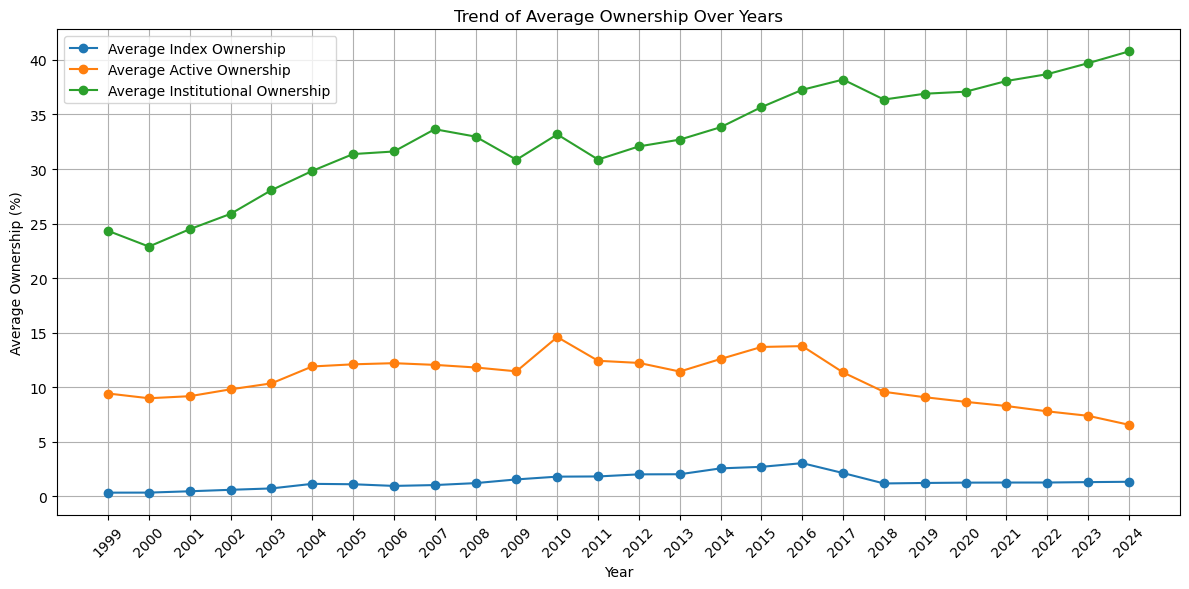

In [232]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each ownership type
plt.plot(summary_own['year'], summary_own['average_index_ownership']*100, label='Average Index Ownership', marker='o')
plt.plot(summary_own['year'], summary_own['average_active_ownership']*100, label='Average Active Ownership', marker='o')
plt.plot(summary_own['year'], summary_inst['average_instit_ownership']*100, label='Average Institutional Ownership', marker='o')

# Adding labels and title
plt.title('Trend of Average Ownership Over Years')
plt.xlabel('Year')
plt.ylabel('Average Ownership (%)')
plt.xticks(summary_own['year'], rotation=45)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid()

# Save the plot to a file
plt.tight_layout()
plt.savefig('average_ownership_trend.png', dpi=300)  # Save as PNG with high resolution
plt.show()

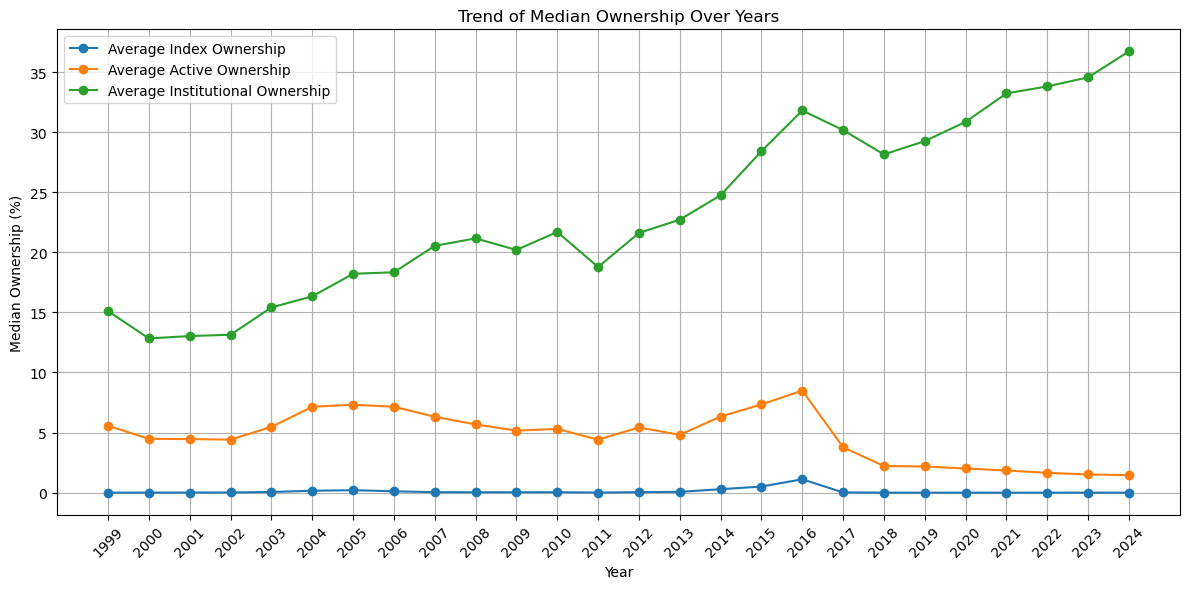

In [233]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each ownership type
plt.plot(summary_own['year'], summary_own['median_index_ownership']*100, label='Average Index Ownership', marker='o')
plt.plot(summary_own['year'], summary_own['median_active_ownership']*100, label='Average Active Ownership', marker='o')
plt.plot(summary_own['year'], summary_inst['median_instit_ownership']*100, label='Average Institutional Ownership', marker='o')

# Adding labels and title
plt.title('Trend of Median Ownership Over Years')
plt.xlabel('Year')
plt.ylabel('Median Ownership (%)')
plt.xticks(summary_own['year'], rotation=45)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid()

# Save the plot to a file
plt.tight_layout()
plt.savefig('median_ownership_trend.png', dpi=300)  # Save as PNG with high resolution
plt.show()